In [68]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np
import fiona 
from geopy import Nominatim #unused but wow!
import cartopy.crs as ccrs #unused
#import geoplot

Data Visualisation sheet (by Stefanie)

In [84]:
# Reading in the joint data table
df_jointdata = pd.read_csv(r'cleaning_data\joint_data.csv')
df_jointdata.drop('Unnamed: 0', axis=1, inplace=True)

In [65]:
# Converting Linestring object to geometry again
df_jointdata['route_linestring'] = gpd.GeoSeries.from_wkt(df_jointdata['route_linestring'])
gdf_jointdata = gpd.GeoDataFrame(df_jointdata, geometry='route_linestring')
gdf_jointdata.set_crs('epsg:3857', inplace=True) # harmonising the CRS (epsg:3857 is also used by OSM and GoogleMaps)
gdf_jointdata.head()

,route_id,route_linestring,num_of_waypoint,waypoint_longitude,waypoint_latitude,poi_lat_lgt,poi_longitude,poi_latitude,poi_category,poi_name,distance
0,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",133,13.67734,52.43849,POINT (13.6774745 52.4385208),13.677475,52.438521,['viewpoint'],Müggeleck,0.000138
1,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",282,13.62759,52.44386,POINT (13.6279051 52.444312),13.627905,52.444312,['bench'],NaN,0.000551
2,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",288,13.62704,52.44442,POINT (13.6271595 52.4444457),13.627159,52.444446,['bench'],NaN,0.000122
3,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",288,13.62704,52.44442,POINT (13.6269487 52.4444808),13.626949,52.444481,['bench'],NaN,0.000110
4,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",292,13.62716,52.44509,POINT (13.6273851 52.4453161),13.627385,52.445316,['bench'],NaN,0.000319


In [70]:
# Creating a child gdf, that would only contain each occuring linestring once
gdf_routesunique = gdf_jointdata.drop_duplicates(subset = ['route_linestring'])

In [101]:
# Reading in a map of post codes in Germany and a csv with post codes corresponding cities and filtering for Berlin
plz_shape_df = gpd.read_file(r'data_visualisation\plz-5stellig.shp', dtype={'plz': str})
plz_region_df = pd.read_csv(r'data_visualisation\zuordnung_plz_ort.csv', sep=',', dtype={'plz': str})
germany_df = pd.merge(left=plz_shape_df, right=plz_region_df, on='plz', how='inner')
berlin_df = germany_df.query('ort == 'Berlin'')
gdf_berlin = gpd.GeoDataFrame(berlin_df)
gdf_berlin.set_crs('epsg:3857', allow_override=True, inplace=True) # harmonising the CRS (epsg:3857 is also used by OSM and GoogleMaps)

,einwohner,note,plz,qkm,geometry,osm_id,ort,bundesland
1082,20313,10115 Berlin Mitte,10115,2.378466,"POLYGON ((13.366 52.536, 13.368 52.537, 13.369...",62422,Berlin,Berlin
1083,12217,10117 Berlin Mitte,10117,3.405881,"POLYGON ((13.374 52.528, 13.374 52.528, 13.375...",62422,Berlin,Berlin
1084,16363,10119 Berlin Mitte,10119,0.977302,"POLYGON ((13.401 52.536, 13.401 52.536, 13.402...",62422,Berlin,Berlin
1085,12167,10178 Berlin Mitte,10178,1.858479,"POLYGON ((13.395 52.524, 13.396 52.524, 13.396...",62422,Berlin,Berlin
1086,18664,10179 Berlin Mitte,10179,2.177671,"POLYGON ((13.403 52.512, 13.405 52.513, 13.405...",62422,Berlin,Berlin
...,...,...,...,...,...,...,...,...
1268,17274,14169 Berlin Zehlendorf,14169,5.098318,"POLYGON ((13.238 52.469, 13.253 52.467, 13.253...",62422,Berlin,Berlin
1269,15505,14193 Berlin Grunewald,14193,20.738295,"POLYGON ((13.192 52.499, 13.195 52.500, 13.199...",62422,Berlin,Berlin
1270,14667,14195 Berlin Dahlem,14195,8.087311,"POLYGON ((13.279 52.475, 13.279 52.475, 13.280...",62422,Berlin,Berlin
1271,17889,14197 Berlin Wilmersdorf,14197,1.587460,"POLYGON ((13.311 52.481, 13.312 52.480, 13.312...",62422,Berlin,Berlin


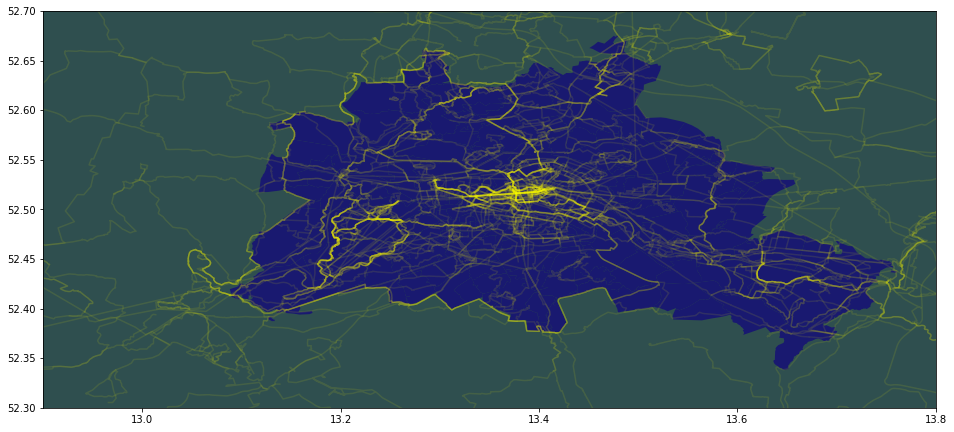

In [125]:
# Printing routes onto map of Berlin
fig, ax = plt.subplots()
gdf_berlin.plot(ax=ax, color='midnightblue')
gdf_routesunique.plot(ax=ax, color='yellow', alpha=0.1)
ax.set_xlim(12.9, 13.8) # restricting the shown longitudes
ax.set_ylim(52.3, 52.7) # restricting the shown latitudes
ax.set_facecolor('darkslategrey') # setting background color

62.0

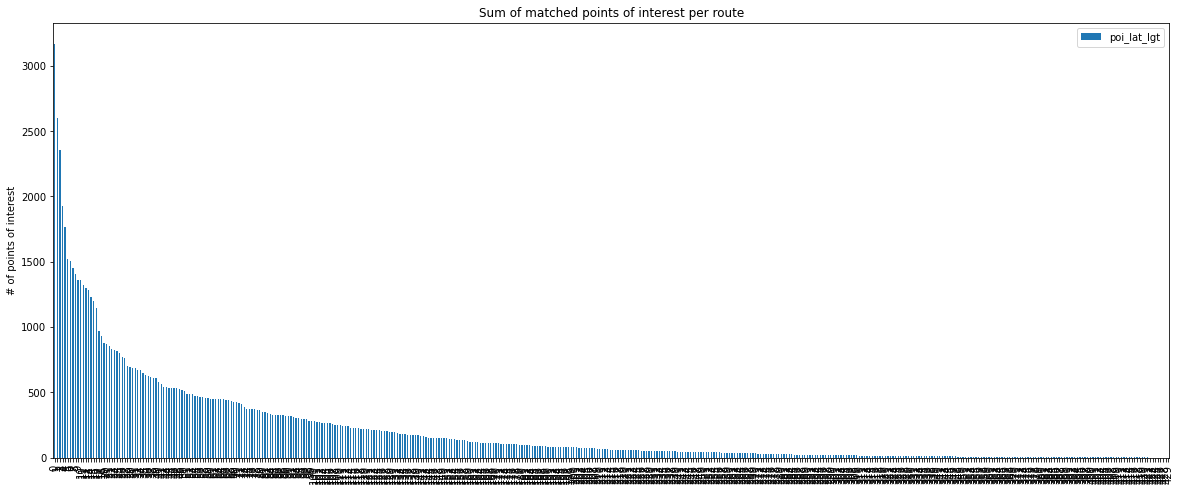

In [39]:
# Summarising the matching points of interest per each route
gdf_poiperroute = gdf_jointdata.groupby(by='route_id').agg({'poi_lat_lgt':'count'}).reset_index().sort_values(by='poi_lat_lgt', ascending=False)
barplot = gdf_poiperroute.plot.bar(x='route_id', xlabel = 'routes', ylabel = '# of points of interest', title='Sum of matched points of interest per route', use_index=False, figsize=(20,8))
gdf_poiperroute['poi_lat_lgt'].median()
# Better to make it with matplotlib ...